# Vacancy analysis

We want to estimate the rate of vacancy hopping, to use this as a way to
1. sanity check what is happening in the proxima "no diffusion case"
2. double-check our MSD-based diffusivity calculations
3. check that the vacancy hops follow the expected distribution, sanity checking our science in general

In [1]:
from pathlib import Path
import json
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from ase.io import read

## Reading the data

we'll start with a full dft trajectory

In [2]:
path = Path('runs/nvt-fixed-temp/si-vacancy-2x2x2-temp=1573.0-method=lda-blend=0-01bd9480/')

In [3]:
with open(path/'params.json') as f: 
    params = json.load(f)
params['min_target_frac'] == 1 # shows us this is a DFT-only run

True

In [4]:
traj = read(path/'md.traj', index=':')

In [5]:
len(traj)

40001

In [6]:
atoms = traj[0]

## Testing the vacancy estimation

First we get all of the minimum image distances

In [7]:
D = atoms.get_all_distances(mic=True)

Text(0, 0.5, 'count')

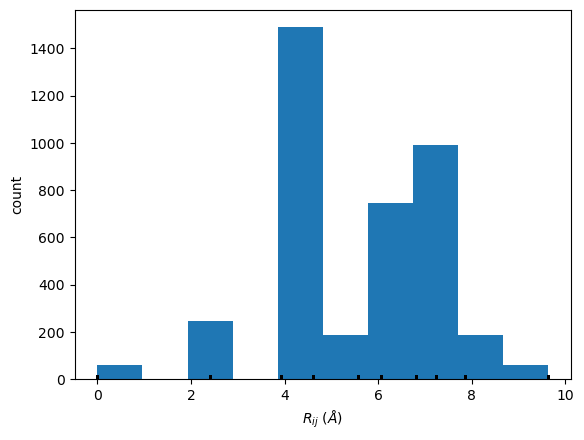

In [8]:
plt.hist(D.ravel());
plt.plot(D.ravel(), [0.1]* len(D.ravel()), '|', color='k');
plt.xlabel('$R_{ij}$ ($\AA$)')
plt.ylabel('count')

The first bin is the self distances (zero), the second bin is likely the covalently bonded Si atoms, lets see what happens if we take a cutoff just above that

In [9]:
r_cut = 3

And then find the number of neighbors

In [10]:
nn = (D < r_cut).sum(1) - 1 # subtract 1 for self distances
pd.Series(nn).value_counts()

4    59
3     4
Name: count, dtype: int64

So 59 of the atoms have 4 neighbors and 4 of them (those near the vacancy) have 3 neighbors. This seems reasonable. 

Heres the n neighbors counts: 

In [11]:
nn

array([3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4])